In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import shap

In [2]:
df = pd.read_csv("../data/ssbci_data_withclusters.csv")
df.loc[df['jobs_created'] > 0, 'creation_status'] = 1
df.loc[df['jobs_created'] == 0, 'creation_status'] = 0
df_expanded = df.copy()
df = df[['ssbci_original_funds', 'jobs_retained','revenue','full_time_employees','loan_investment_amount', 'SPY_Close','creation_status']]
df_expanded = df_expanded[['ssbci_original_funds', 'jobs_retained','revenue','full_time_employees','loan_investment_amount', 
                           'SPY_Close', 'kproto','creation_status']]

#df_expanded.drop(['Unnamed: 0','borrower_insurance_premium','lender_insurance_premium','jobs_created','job_benefit'], axis=1, inplace=True)
df.columns

Index(['ssbci_original_funds', 'jobs_retained', 'revenue',
       'full_time_employees', 'loan_investment_amount', 'SPY_Close',
       'creation_status'],
      dtype='object')

In [3]:
ssbci_obj_cols = df_expanded.select_dtypes(exclude=[np.float64]).columns
#ssbci_int_cols = [['naics_code','year_incorporated']]
#ssbci_obj_cols.append(ssbci_int_cols)
ssbci_obj_cols

Index(['kproto'], dtype='object')

In [4]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
for i in ssbci_obj_cols:
    df_expanded[i] = label_encoder.fit_transform(df_expanded[i])

print("Label Encoded Data: ")
df_expanded.head()

Label Encoded Data: 


,ssbci_original_funds,jobs_retained,revenue,full_time_employees,loan_investment_amount,SPY_Close,kproto,creation_status
0,90000.0,1.0,0.0,5.0,180000.0,152.110001,8,1.0
1,250000.0,0.0,0.0,28.0,2400000.0,167.509995,3,1.0
2,110000.0,5.0,0.0,7.0,265000.0,183.820007,8,1.0
3,99750.0,0.0,0.0,2.0,199500.0,181.509995,8,1.0
4,62500.0,0.0,1494916.0,8.0,125000.0,187.399994,5,1.0


In [5]:
X = df.copy()
X.drop("creation_status", inplace = True, axis = 1)
Y = df.creation_status

In [6]:
#X_train, X_test = X[:int(X.shape[0]*0.8)].values, X[int(X.shape[0]*0.8):].values
#Y_train, Y_test = Y[:int(X.shape[0]*0.8)].values, Y[int(X.shape[0]*0.8):].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
test_size=0.2, random_state=42)


In [7]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, f1_score, recall_score


boost = GradientBoostingClassifier(max_depth=10)
boost.fit(X_train, Y_train)
y_pred_boost = boost.predict(X_test)
print('Confusion matrix')
print(confusion_matrix(Y_test, y_pred_boost))
print('Accuracy score')
ac = accuracy_score(Y_test, y_pred_boost)
print(ac)
print('Precision score')
pr = precision_score(Y_test, y_pred_boost)
print(pr)
print('Recall score')
re = recall_score(Y_test, y_pred_boost)
print(re)
print('F1 score')
f1 = f1_score(Y_test, y_pred_boost)
print(f1)

Confusion matrix
[[1987  547]
 [ 509 1350]]
Accuracy score
0.7596175734122468
Precision score
0.7116499736425935
Recall score
0.7261968800430338
F1 score
0.7188498402555911


In [8]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from numpy import mean
from numpy import std
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

score = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}


# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# evaluate model
scores = cross_validate(boost, X, Y, scoring=score, cv=cv, n_jobs=-1)
# report performance
#print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
print(scores)

{'fit_time': array([15.37561178, 15.42166162, 13.87055016, 15.27465796, 14.48053575,
       14.80158472, 13.60353422, 15.34673834,  8.41242719,  8.18339562]), 'score_time': array([0.02897072, 0.01752353, 0.04397058, 0.02700901, 0.0450201 ,
       0.02797508, 0.0449965 , 0.02397919, 0.0169549 , 0.01695442]), 'test_accuracy': array([0.75011379, 0.77651343, 0.76320583, 0.75      , 0.7636612 ,
       0.75      , 0.74772313, 0.76138434, 0.75774135, 0.74863388]), 'test_precision': array([0.71868583, 0.72783505, 0.71835443, 0.70106383, 0.73120494,
       0.70664024, 0.69637306, 0.73152966, 0.70719352, 0.69351464]), 'test_recall': array([0.71794872, 0.75669882, 0.72912206, 0.71089536, 0.73347107,
       0.73809524, 0.72025723, 0.7254902 , 0.74176408, 0.71908894]), 'test_f1_score': array([0.71831709, 0.74198634, 0.72369819, 0.70594537, 0.73233626,
       0.72202532, 0.7081138 , 0.72849741, 0.72406639, 0.70607029])}


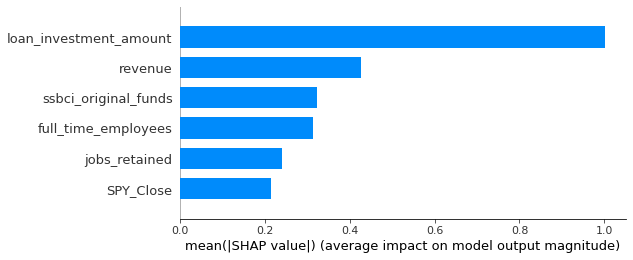

In [9]:
import shap

explainer_km = shap.TreeExplainer(boost)
shap_values_km = explainer_km.shap_values(X)
shap.summary_plot(shap_values_km, X, plot_type="bar")

In [10]:
Xe = df_expanded.copy()
Xe.drop("creation_status", inplace = True, axis = 1)
Ye = df_expanded.creation_status

In [11]:
Xe_train, Xe_test, Ye_train, Ye_test = train_test_split(Xe, Ye,
test_size=0.2, random_state=42)

In [12]:
boost_expanded = GradientBoostingClassifier(max_depth=10)
boost_expanded.fit(Xe_train, Ye_train)
ye_pred_boost = boost_expanded.predict(Xe_test)
print('Confusion matrix')
print(confusion_matrix(Ye_test, ye_pred_boost))
print('Accuracy score')
ace = accuracy_score(Ye_test, ye_pred_boost)
print(ace)
print('Precision score')
pre = precision_score(Ye_test, ye_pred_boost)
print(pre)
print('Recall score')
ree = recall_score(Ye_test, ye_pred_boost)
print(ree)
print('F1 score')
f1e = f1_score(Ye_test, ye_pred_boost)
print(f1e)

Confusion matrix
[[2013  521]
 [ 498 1361]]
Accuracy score
0.7680400637377647
Precision score
0.7231668437832094
Recall score
0.7321140398063475
F1 score
0.7276129377171879


In [13]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from numpy import mean
from numpy import std
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

score = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}


# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# evaluate model
scores = cross_validate(boost_expanded, X, Y, scoring=score, cv=cv, n_jobs=-1)
# report performance
#print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
print(scores)

{'fit_time': array([14.18217397, 14.13729453, 14.22257519, 14.15225482, 14.44848323,
       14.50233865, 14.58961511, 14.87536073,  8.28885508,  8.36214972]), 'score_time': array([0.02942967, 0.02493334, 0.02892232, 0.02991962, 0.0269289 ,
       0.02792525, 0.0259304 , 0.01994705, 0.01894903, 0.01595712]), 'test_accuracy': array([0.75512062, 0.77196177, 0.76183971, 0.74408015, 0.75728597,
       0.74772313, 0.75364299, 0.76502732, 0.76047359, 0.74863388]), 'test_precision': array([0.72318693, 0.72832981, 0.7197861 , 0.69230769, 0.72171254,
       0.70355731, 0.70164609, 0.73135853, 0.70896274, 0.69151139]), 'test_recall': array([0.72615385, 0.73847803, 0.72055675, 0.70873786, 0.73140496,
       0.73706004, 0.73097535, 0.73890609, 0.74814028, 0.72451193]), 'test_f1_score': array([0.72466735, 0.73336881, 0.72017121, 0.70042644, 0.72652642,
       0.71991911, 0.7160105 , 0.73511294, 0.72802482, 0.70762712])}


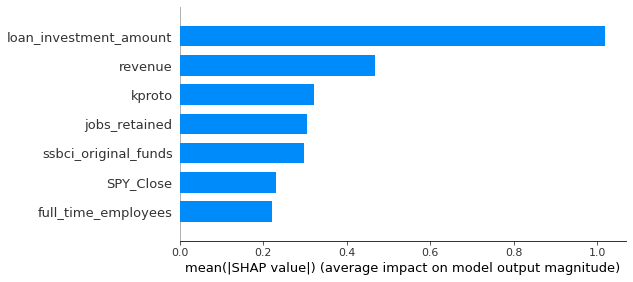

In [14]:
explainer_km = shap.TreeExplainer(boost_expanded)
shap_values_km = explainer_km.shap_values(Xe)
shap.summary_plot(shap_values_km, Xe, plot_type="bar")

In [21]:
import pickle
pickle.dump(boost, open("model.dat", "wb"))

In [18]:
import joblib
joblib.dump(boost, 'model.pkl')
print("Model dumped!")

Model dumped!


In [19]:
# Load the model that you just saved
model = joblib.load('model.pkl')

# Saving the data columns from training
model_columns = list(X.columns)
joblib.dump(model_columns, 'model_columns.pkl')
print("Models columns dumped!")


Models columns dumped!
